In [1]:
#export
import k1lib, base64, io, torch, os, matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np
from typing import Callable, List, Union
from functools import partial, update_wrapper
__all__ = ["SliceablePlot", "plotSegments", "Carousel", "confusionMatrix", "FAnim"]

In [2]:
#export
class _PlotDecorator:
    """The idea with decorators is that you can do something like this::

    sp = k1lib.viz.SliceablePlot()
    sp.yscale("log") # will format every plot as if ``plt.yscale("log")`` has been called

This class is not expected to be used by end users though."""
    def __init__(self, sliceablePlot:"SliceablePlot", name:str):
        """
:param sliceablePlot: the parent plot
:param name: the decorator's name, like "yscale" """
        self.sliceablePlot = sliceablePlot
        self.name = name; self.args, self.kwargs = None, None
    def __call__(self, *args, **kwargs):
        """Stores all args, then return the parent :class:`SliceablePlot`"""
        self.args = args; self.kwargs = kwargs; return self.sliceablePlot
    def run(self): getattr(plt, self.name)(*self.args, **self.kwargs)

In [3]:
#export
class SliceablePlot:
    """This is a plot that is "sliceable", meaning you can focus into
a particular region of the plot quickly. A minimal example looks something
like this::

    import numpy as np, matplotlib.pyplot as plt, k1lib
    x = np.linspace(-2, 2, 100)
    
    def normalF():
        plt.plot(x, x**2)
    
    @k1lib.viz.SliceablePlot.decorate
    def plotF(_slice):
        plt.plot(x[_slice], (x**2)[_slice])
        
    plotF()[70:] # plots x^2 equation with x in [0.8, 2]

So, ``normalF`` plots the equation :math:`x^2` with x going from -2 to 2.
You can convert this into a :class:`SliceablePlot` by adding a term of
type :class:`slice` to the args, and decorate with :meth:`decorate`. Now,
every time you slice the :class:`SliceablePlot` with a specific range,
``plotF`` will receive it.

How intuitive everything is depends on how you slice your data. ``[70:]``
results in x in [0.8, 2] is rather unintuitive. You can change it into
something like this::

    @k1lib.viz.SliceablePlot.decorate
    def niceF(_slice):
        n = 100; r = k1lib.Range(-2, 2)
        x = np.linspace(*r, n)
        _slice = r.toRange(k1lib.Range(n), r.bound(_slice)).slice_
        plt.plot(x[_slice], (x**2)[_slice])
    # this works without a decorator too btw: k1lib.viz.SliceablePlot(niceF)

    niceF()[0.3:0.7] # plots x^2 equation with x in [0.3, 0.7]
    niceF()[0.3:] # plots x^2 equation with x in [0.3, 2]

The idea is to just take the input :class:`slice`, put some bounds on
its parts, then convert that slice from [-2, 2] to [0, 100]. Check
out :class:`k1lib.Range` if it's not obvious how this works.

A really cool feature of :class:`SliceablePlot` looks like this::

    niceF().legend(["A"])[-1:].grid(True).yscale("log")

This will plot :math:`x^2` with range in [-1, 2] with a nice grid, and
with y axis's scale set to log. Essentially, undefined method calls
on a :class:`SliceablePlot` will translate into ``plt`` calls. So the
above is roughly equivalent to this::

    x = np.linspace(-2, 2, 100)
    plt.plot(x, x**2)
    plt.legend(["A"])
    plt.grid(True)
    plt.yscale("log")

.. image:: images/SliceablePlot.png

This works even if you have multiple axes inside your figure. It's
wonderful, isn't it?"""
    def __init__(self, plotF:Callable[[slice], None], slices:Union[slice, List[slice]]=slice(None), plotDecorators:List[_PlotDecorator]=[], docs=""):
        """Creates a new SliceablePlot. Only use params listed below:

:param plotF: function that takes in a :class:`slice` or tuple of :class:`slice`s
:param docs: optional docs for the function that will be displayed in :meth:`__repr__`"""
        self.plotF = plotF
        self.slices = [slices] if isinstance(slices, slice) else slices
        self.docs = docs; self.plotDecorators = list(plotDecorators)
    @staticmethod
    def decorate(f):
        """Decorates a plotting function so that it becomes a
SliceablePlot."""
        answer = partial(SliceablePlot, plotF=f)
        update_wrapper(answer, f)
        return answer
    @property
    def squeezedSlices(self) -> Union[List[slice], slice]:
        """If :attr:`slices` only has 1 element, then return that
element, else return the entire list."""
        return k1lib.squeeze(self.slices)
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        # automatically assume the attribute is a plt.attr method
        dec = _PlotDecorator(self, attr)
        self.plotDecorators.append(dec); return dec
    def __getitem__(self, idx):
        if type(idx) == slice:
            return SliceablePlot(self.plotF, [idx], self.plotDecorators, self.docs)
        if type(idx) == tuple and all([isinstance(elem, slice) for elem in idx]):
            return SliceablePlot(self.plotF, idx, self.plotDecorators, self.docs)
        raise Exception(f"Don't understand {idx}")
    def __repr__(self):
        self.plotF(self.squeezedSlices)
        for ax in plt.gcf().get_axes():
            plt.sca(ax)
            for decorator in self.plotDecorators: decorator.run()
        plt.show()
        return f"""Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt{self.docs}"""

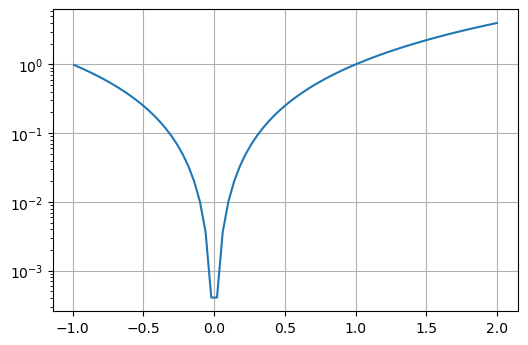

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [4]:
@SliceablePlot.decorate
def plotF(_slice):
    n = 100; r = k1lib.Range(-2, 2)
    x = np.linspace(*r, n)
    _slice = r.toRange(k1lib.Range(n), r.bound(_slice)).slice_
    plt.plot(x[_slice], (x**2)[_slice])
plotF()[-1:].grid(True).yscale("log")

In [5]:
#export
def plotSegments(x:List[float], y:List[float], states:List[int], colors:List[str]=None):
    """Plots a line graph, with multiple segments with different colors.

:param x: (nullable) list of x coordinate at each point
:param y: list of y coordinates at each point
:param states: list of color at each point
:param colors: string colors to display for each states

Idea is, you have a normal line graph, but you want to color parts of
the graph red, other parts blue. Then, you can pass a "state" array, with
the same length as your data, filled with ints, like this::

    y = np.array([ 460800,  921600,  921600, 1445888, 1970176, 1970176, 2301952,
           2633728, 2633728, 3043328, 3452928, 3452928, 3457024, 3461120,
           3463680, 3463680, 3470336, 3470336, 3467776, 3869184, 3865088,
           3865088, 3046400, 2972672, 2972672, 2309632, 2504192, 2504192,
           1456128, 1393664, 1393664,  472576])
    s = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
    plotSegments(None, y, s, colors=["tab:blue", "tab:red"])
    
.. image:: images/plotSegments.png
"""
    if x is None: x = range(len(y))
    if colors is None: colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "tab:brown"][:len(x)]
    _x = []; _y = []; state = -1; count = -1 # stretchs, and bookkeeping nums
    lx = None; ly = None # last x and y from last stretch, for plot autocompletion
    while count + 1 < len(x):
        count += 1
        if state != states[count]:
            if len(_x) > 0 and state >= 0:
                if lx != None: _x = [lx] + _x; _y = [ly] + _y
                plt.plot(_x, _y, colors[state]); lx = _x[-1]; ly = _y[-1]
            _x = [x[count]]; _y = [y[count]]; state = states[count]
        else: _x.append(x[count]); _y.append(y[count])
    if len(_x) > 0 and state >= 0:
        if lx != None: _x = [lx] + _x; _y = [ly] + _y
        plt.plot(_x, _y, colors[state])

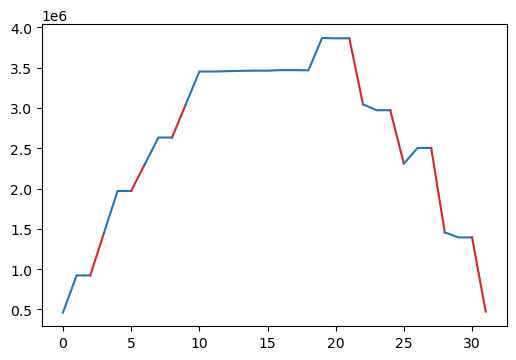

In [6]:
y = np.array([ 460800,  921600,  921600, 1445888, 1970176, 1970176, 2301952,
       2633728, 2633728, 3043328, 3452928, 3452928, 3457024, 3461120,
       3463680, 3463680, 3470336, 3470336, 3467776, 3869184, 3865088,
       3865088, 3046400, 2972672, 2972672, 2309632, 2504192, 2504192,
       1456128, 1393664, 1393664,  472576])
s = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
plotSegments(None, y, s, colors=["tab:blue", "tab:red"])

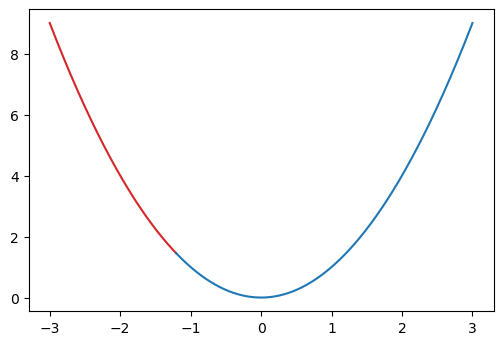

In [7]:
x = np.linspace(-3, 3, 1000)
states = np.zeros(1000, dtype=np.int); states[:300] = 1
colors = ["tab:blue", "tab:red"]
plotSegments(x, x**2, states)
#plt.show()

In [8]:
#export
class Carousel:
    _idx = k1lib.AutoIncrement.random()
    def __init__(self):
        """Creates a new Carousel. You can then add images and whatnot.
Will even work even when you export the notebook as html. Example::

    import numpy as np, matplotlib.pyplot as plt, k1lib
    c = k1lib.viz.Carousel()
    x = np.linspace(-2, 2); plt.plot(x, x ** 2); c.savePlt()
    x = np.linspace(-1, 3); plt.plot(x, x ** 2); c.savePlt()
    c # displays in notebook cell

.. image:: images/carousel.png
"""
        self.imgs:List[Tuple[str, str]] = [] # Tuple[format, base64 img]
        self.defaultFormat = "jpeg"
    def saveBytes(self, _bytes:bytes, fmt:str=None):
        """Saves bytes as another image.

:param fmt: format of image"""
        self.imgs.append((fmt or self.defaultFormat, base64.b64encode(_bytes).decode()))
    def save(self, f:Callable[[io.BytesIO], None]):
        """Generic image save function. Treat :class:`io.BytesIO` as if it's
a file when you're doing this::
    
    with open("file.txt") as f:
        pass # "f" is similar to io.BytesIO

So, you can do stuff like::

    import matplotlib.pyplot as plt, numpy as np
    x = np.linspace(-2, 2)
    plt.plot(x, x**2)
    c = k1lib.viz.Carousel()
    c.save(lambda io: plt.savefig(io, format="png"))

:param f: lambda that provides a :class:`io.BytesIO` for you to write to
"""
        byteArr = io.BytesIO(); f(byteArr); byteArr.seek(0)
        self.saveBytes(byteArr.read())
    def savePlt(self):
        """Saves current plot from matplotlib"""
        self.save(lambda byteArr: plt.savefig(byteArr, format=self.defaultFormat))
        plt.clf()
    def savePIL(self, image):
        """Saves a PIL image"""
        self.save(lambda byteArr: image.save(byteArr, format=self.defaultFormat))
    def saveFile(self, fileName:str, fmt:str=None):
        """Saves image from file.

:param fmt: format of the file. Will figure out from file extension
    automatically if left empty
"""
        with open(fileName, "rb") as f:
            if fmt is None: # automatically infer image format
                baseName = os.path.basename(fileName)
                if "." in baseName: fmt = baseName.split(".")[-1]
            self.saveBytes(f.read(), fmt)
    def saveGraphviz(self, g):
        """Saves a graphviz graph"""
        import tempfile; a = tempfile.NamedTemporaryFile()
        g.render(a.name, format="jpeg"); self.saveFile(f"{a.name}.jpeg")
    def pop(self):
        """Pops last image"""
        return self.imgs.pop()
    def __getitem__(self, idx): return self.imgs[idx]
    def _repr_html_(self):
        imgs = [f"\"<img src='data:image/{fmt};base64, {img}' />\"" for fmt, img in self.imgs]
        idx = Carousel._idx.value
        pre = f"k1c_{idx}"
        html = f"""
<style>
    .{pre}_btn {{
        cursor: pointer;
        padding: 10px 15px;
        background: #9e9e9e;
        float: left;
        margin-right: 5px;
        color: #000;
        user-select: none
    }}
    .{pre}_btn:hover {{
        background: #4caf50;
        color: #fff;
    }}
</style>
<div>
    <div id="{pre}_prevBtn" class="{pre}_btn">Prev</div>
    <div id="{pre}_nextBtn" class="{pre}_btn">Next</div>
    <div style="clear:both"/>
    <div id="{pre}_status" style="padding: 10px"></div>
</div>
<div id="{pre}_imgContainer"></div>
<script>
    {pre}_imgs = [{','.join(imgs)}];
    {pre}_imgIdx = 0;
    function {pre}_display() {{
        document.querySelector("#{pre}_imgContainer").innerHTML = {pre}_imgs[{pre}_imgIdx];
        document.querySelector("#{pre}_status").innerHTML = "Image: " + ({pre}_imgIdx + 1) + "/" + {pre}_imgs.length;
    }};
    document.querySelector("#{pre}_prevBtn").onclick = () => {{
        {pre}_imgIdx -= 1;
        {pre}_imgIdx = Math.max({pre}_imgIdx, 0);
        {pre}_display();
    }};
    document.querySelector("#{pre}_nextBtn").onclick = () => {{
        {pre}_imgIdx += 1;
        {pre}_imgIdx = Math.min({pre}_imgIdx, {pre}_imgs.length - 1);
        {pre}_display();
    }};
    {pre}_display();
</script>
        """
        return html

In [9]:
c = Carousel()
x = np.linspace(-2, 2); plt.plot(x, x ** 2); c.savePlt()
x = np.linspace(-1, 3); plt.plot(x, x ** 2); c.savePlt(); c

<Figure size 600x400 with 0 Axes>

In [10]:
#export
def confusionMatrix(matrix:torch.Tensor, categories:List[str]=None, **kwargs):
    """Plots a confusion matrix. Example::

    k1lib.viz.confusionMatrix(torch.rand(5, 5), ["a", "b", "c", "d", "e"])

.. image:: images/confusionMatrix.png

:param matrix: 2d matrix of shape (n, n)
:param categories: list of string categories
:param kwargs: keyword args passed into :meth:`plt.figure`"""
    if isinstance(matrix, torch.Tensor): matrix = matrix.numpy()
    if categories is None: categories = [f"{e}" for e in range(len(matrix))]
    fig = plt.figure(**{"dpi":100, **kwargs}); ax = fig.add_subplot(111)
    cax = ax.matshow(matrix); fig.colorbar(cax)

    with k1lib.ignoreWarnings():
        ax.set_xticklabels([''] + categories, rotation=90)
        ax.set_yticklabels([''] + categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_label_position('top')
    plt.xlabel("Predictions"); plt.ylabel("Ground truth")

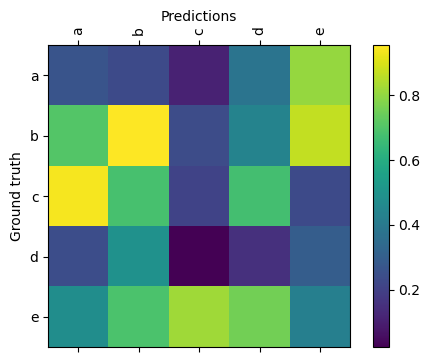

In [11]:
confusionMatrix(torch.rand(5, 5), ["a", "b", "c", "d", "e"])

In [12]:
c = Carousel()
confusionMatrix(torch.rand(5, 5), ["a", "b", "c", "d", "e"])
c.savePlt(); assert len(c[0][1]) > 10000; c

<Figure size 600x400 with 0 Axes>

In [13]:
#export
def FAnim(fig, f, frames, *args, **kwargs):
    """Matplotlib function animation, 60fps. Example::

    # line below so that the animation is displayed in the notebook. Included in :mod:`k1lib.imports` already, so you don't really have to do this!
    plt.rcParams["animation.html"] = "jshtml"
    x = np.linspace(-2, 2); y = x**2
    fig, ax = plt.subplots()
    plt.close() # close cause it'll display 1 animation, 1 static if we don't do this
    def f(frame):
        ax.clear()
        ax.set_ylim(0, 4); ax.set_xlim(-2, 2)
        ax.plot(x[:frame], y[:frame])
    k1lib.FAnim(fig, f, len(x)) # plays animation in cell

:param fig: figure object from `plt.figure(...)` command
:param f: function that accepts 1 frame from `frames`.
:param frames: number of frames, or iterator, to pass into function"""
    return partial(mpl.animation.FuncAnimation, interval=1000/30)(fig, f, frames, *args, **kwargs)

In [14]:
plt.rcParams["animation.html"] = "jshtml"
x = np.linspace(-2, 2); y = x**2
fig, ax = plt.subplots()
plt.close() # close cause it'll display 1 animation, 1 static if we don't do this
def f(frame):
    ax.clear()
    ax.set_ylim(0, 4); ax.set_xlim(-2, 2)
    ax.plot(x[:frame], y[:frame])
FAnim(fig, f, len(x)); # plays animation in cell

In [15]:
!../export.py viz

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.3
Uninstalling k1lib-0.3:
  Successfully uninstalled k1lib-0.3
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/data.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib/_baseClasse